# 🏆 Predicting Methane Absorption in Porous Materials

[*"In Silico Design of 2D and 3D Covalent Organic Frameworks for Methane Storage Applications"*](https://archive.materialscloud.org/record/2018.0003/v2) introduces a comprehensive database of 69,840 covalent organic frameworks (COFs), each virtually assembled from 666 unique organic linkers and synthesized via four distinct methods. Using grand-canonical Monte Carlo simulations, the study evaluated the methane storage capacity of these frameworks, identifying top-performing materials, outperforming the best methane storage materials currently available.

This notebook offers a hands-on experience for participants to learn machine learning by analyzing and modeling this real-world dataset. Participants will apply ML techniques to uncover patterns and develop predictive models for COFs' methane storage capacity. The full dataset is available on [Materials Cloud](https://archive.materialscloud.org/record/2018.0003/v2).

- **voidFraction**: Porosity or percentage of void space in the material.
- **supercellVolume**: Volume of the supercell structure used for modeling.
- **density**: Density of the material.
- **cell_a, cell_b, cell_c**: Supercell dimensions in angstroms.
- **alpha_deg, beta_deg, gamma_deg**: Angles of the supercell structure in degrees.
- **num_carbon, num_fluorine, etc.**: Counts of specific atoms (e.g., carbon, fluorine).
- **largest_incl_sphere**: Largest sphere that fits within the material.
- **largest_free_sphere**: Largest sphere that can move freely within the material.
- **largest_incl_sphere_along_path**: Largest sphere that can fit along a path in the material.
- **`highUptake_mol` (Target Variable)**: Amount of methane adsorbed within the porous material.

<figure align="center" class="image">
  <img src="https://www.zeoplusplus.org/spheres.png">
  <figcaption>(1) the largest included sphere (Di), (2) the largest free sphere (Df), and (3) the largest included sphere along the free sphere path (Dif).</figcaption>
</figure>

---

## 🤔 What’s the Plan?

We’ll walk through a complete machine learning workflow, covering everything from exploration to deployment. Here’s our approach:

1. **Exploratory Data Analysis (EDA)**: We'll begin by loading the dataset and performing thorough exploratory data analysis to uncover patterns, detect anomalies, and identify potential relationships between features. This will guide our data preprocessing and modeling decisions.
2. **Data Preprocessing**: Based on the findings from EDA, we’ll handle missing values, normalize or scale the data, address outliers, and remove irrelevant features to prepare the dataset for modeling.
3. **Build and Evaluate the Model**: Next, we'll train multiple machine learning models, evaluate their performance using appropriate metrics, and select the best-performing model for our task.
4. **Test on Previously Unseen Data**: Finally, we'll validate the selected model by testing it on a separate, previously unseen dataset to assess its generalization ability and performance in real-world scenarios.

> 💡 Guidance blocks like this will appear throughout the notebook to help you implement the necessary functionality and move forward in the challenge.

> ✍️ Blocks like this one will require you to write down your observations and insights.


## 📦 Installing the Necessary Dependencies

We first need to install the necessary python dependencies:

- [`pandas`](https://github.com/pandas-dev/pandas) is a powerful data manipulation and analysis library for Python. It provides data structures, like DataFrames, which make it easy to work with structured data, similar to tables in Excel or SQL. You can use pandas to clean, transform, and analyze data effectively.
- [`scikit-learn`](https://github.com/scikit-learn/scikit-learn) is a widely used machine learning library in Python. It offers a range of tools for building and evaluating machine learning models, including classification, regression, clustering, and dimensionality reduction. Scikit-learn is great for experimenting with models and understanding core ML concepts.
- [`matplotlib`](https://github.com/matplotlib/matplotlib) is a foundational plotting library in Python. It provides extensive control over plots, making it useful for creating static, high-quality visuals for data analysis. Matplotlib is also the base upon which many other plotting libraries, like seaborn, are built.
- [`seaborn`](https://github.com/mwaskom/seaborn) is a data visualization library built on top of Matplotlib. It provides a high-level interface for drawing attractive statistical graphics and is especially useful for data exploration and creating visually appealing plots with minimal code.
- [`tqdm`](https://github.com/tqdm/tqdm) is a Python library used for creating progress bars, which make it easy to monitor the progress of loops or tasks in your code. It’s especially handy when running long operations, like data processing or training machine learning models, as it gives a real-time view of how much work is left. You can add tqdm to any iterable, and it will automatically display a progress bar that updates as the loop iterates.

In [1]:
!python -m pip install pandas==2.2.3 scikit-learn==1.5.2 tqdm==4.67.0 matplotlib==3.9.2 seaborn==0.13.2

Let's import the required dependencies.

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm.notebook import tqdm

## ♾️ Reproducibility

[Reproducibility](https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html) in ML experiments is crucial for verifying results, ensuring consistency, and enabling others to build upon your work.

**But how do we achieve reproducibility when randomness is involved?** In ML tasks like splitting datasets or initializing models, randomness is often needed. However, computers don’t generate true randomness—they use deterministic algorithms to produce sequences of seemingly random numbers. These algorithms start with a "random seed"—a fixed initial value. Think of it as a starting point in a recipe: no matter how many times you follow the same steps with the same seed, you’ll always get the same result. By fixing this seed, the sequence of numbers produced by the algorithm remains identical across runs, ensuring consistency in experiments.

In [3]:
print("Matrix A")
print(np.random.rand(1, 20))

print("Matrix B")
print(np.random.rand(1, 20))

Matrix A
[[0.33299291 0.45519018 0.39869526 0.39158632 0.69142686 0.54528554
  0.82356346 0.69155153 0.04022055 0.38934499 0.2538064  0.91662172
  0.02730687 0.89998648 0.07384017 0.78263398 0.64000261 0.64629044
  0.9002012  0.5019748 ]]
Matrix B
[[0.33829773 0.60311723 0.94237552 0.23902173 0.16118155 0.62870494
  0.91359347 0.25141004 0.64375992 0.17290483 0.1013623  0.34789502
  0.00254128 0.23167054 0.9147007  0.83705472 0.12958314 0.18150633
  0.27498937 0.6639849 ]]


As you can see, not setting a random seed leads to different numbers being generated each time.

> 💡 Setting a random seed ensures reproducibility by [controlling the random number generation](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness). You can set a global seed to consistently control randomness throughout your codebase. However, some scikit-learn objects, require the `random_state` parameter to be explicitly set. This parameter ensures they manage randomness locally, even when a global seed is in place.

In [4]:
RANDOM_SEED = 1234

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Matrix A")
print(np.random.rand(1, 20))

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Matrix B")
print(np.random.rand(1, 20))

Matrix A
[[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581 0.27259261
  0.27646426 0.80187218 0.95813935 0.87593263 0.35781727 0.50099513
  0.68346294 0.71270203 0.37025075 0.56119619 0.50308317 0.01376845
  0.77282662 0.88264119]]
Matrix B
[[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581 0.27259261
  0.27646426 0.80187218 0.95813935 0.87593263 0.35781727 0.50099513
  0.68346294 0.71270203 0.37025075 0.56119619 0.50308317 0.01376845
  0.77282662 0.88264119]]


## ⛏️ Dataset Preprocessing

Preprocessing prepares our dataset by transforming raw data into a suitable format for modeling. [Consistent](https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing) preprocessing is crucial for optimal model performance. For a detailed overview of techniques, refer to the [scikit-learn guide](https://scikit-learn.org/1.5/modules/preprocessing.html).

> 💡 Begin by loading the dataset using [`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). Next, identify your target variable and features.

In [6]:
df = pd.read_csv("./data/train.csv")

target_variable = "highUptake_mol"
features = list(set(df.columns).difference([target_variable, "id"]))

We first need to check and remove any NaNs. A **NaN (Not a Number)** is a placeholder used to represent missing, undefined, or unrepresentable values in a dataset, such as the result of a division by zero or a failed data entry. NaNs can appear in a dataset due to various reasons, including incomplete data collection, errors during data processing, or invalid calculations. NaNs need to be removed because most ML models cannot handle missing values and may produce incorrect results or errors.

> 💡 Use [`pandas.DataFrame.isna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html) to identify NaNs, then apply [`pandas.DataFrame.sum`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html) to count the missing values in each column. To remove rows with any missing values, use [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

In [7]:
df.isna().sum().rename("Missing Values")

voidFraction                      2098
supercellVolume                   2090
density                           2126
highUptake_mol                    2032
cell_a                            2092
cell_b                            2120
cell_c                            2140
alpha_deg                         2039
beta_deg                          2110
gamma_deg                         2076
num_carbon                           0
num_fluorine                         0
num_hydrogen                         0
num_nitrogen                         0
num_oxygen                           0
num_sulfur                           0
num_silicon                          0
largest_incl_sphere               2110
largest_free_sphere               2146
largest_incl_sphere_along_path    2075
id                                   0
Name: Missing Values, dtype: int64

In [8]:
df.dropna(inplace=True)

Before moving forward, we need to split our dataset. Splitting the dataset is essential for evaluating the performance of a machine learning model. This ensures that we can test the model on data it hasn't seen during training, providing an unbiased estimate of its ability to generalize to unseen data.

1. **Define Features and Target:** Separate the dataset into input features (`X`) and the target variable (`y`) that the model will predict.
2. **Train-Test Split:** Randomly divide the data into training and testing subsets, typically with a ratio like 80%-20%. The training set is used for learning, and the test set is reserved for evaluation.

> 💡 Use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split datasets into training and testing sets. Set the `random_state` parameter to ensure reproducibility.

In [9]:
X, y = df[features], df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

## ⛵ Model Exploration

### Linear Regression

[**Linear Regression**](https://scikit-learn.org/1.5/modules/linear_model.html) is a method used to model the relationship between a dependent variable $y$ and one or more independent variables $X$ by fitting a linear equation to observed data. The goal is to find the best-fitting line that minimizes the error between predicted and actual values.

The equation for multiple linear regression is:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon$$

Where:
- $y$ is the predicted value,
- $x_1, x_2, \dots, x_n$ are the input features,
- $\beta_0$ is the intercept,
- $\beta_1, \beta_2, \dots, \beta_n$ are the coefficients,
- $\epsilon$ is the error term.

The model is trained by minimizing the Mean Squared Error (MSE), defined as:

$$MSE = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2$$

Where:
- $m$ is the number of data points,
- $y_i$ is the actual value,
- $\hat{y}_i$ is the predicted value.

Minimizing MSE helps the model find the best-fitting coefficients to accurately predict $y$.

> 💡 Use [sklearn.linear_model.LinearRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html) to fit a linear regression model to the training data and predict the test set. Then, create a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to display the true and predicted values side by side.

In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

pd.DataFrame({"True": y_test, "Pred": model.predict(X_test)})

,True,Pred
47612,35.537545,39.483556
36643,47.123921,41.834264
40776,48.868551,38.913153
21895,21.723829,26.053595
11568,31.078080,34.276903
...,...,...
3920,31.423012,35.934032
38032,32.034102,34.834538
52975,32.585080,40.015447
64925,35.205061,34.277595


### Lasso Regression

[**Lasso Regression**](https://scikit-learn.org/1.5/modules/linear_model.html#lasso) (Least Absolute Shrinkage and Selection Operator) is a type of linear regression. It penalizes the absolute values of the coefficients, forcing some of them to shrink to zero, which effectively excludes less important features.

The equation for Lasso Regression is similar to linear regression but adds a regularization term:

$$\text{Objective: } \min_\beta \left(\frac{1}{2m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{n} |\beta_j| \right)$$

Where:
- $y_i$ is the actual value,
- $\hat{y}_i$ is the predicted value,
- $\beta_j$ are the coefficients,
- $m$ is the number of data points,
- $n$ is the number of features,
- $\alpha$ is the regularization strength (larger $\alpha$ increases penalty, shrinking more coefficients to zero).

The L1 penalty ($\sum |\beta_j|$):
- Encourages sparsity by shrinking coefficients of less important features to zero,
- Helps in feature selection when many features are irrelevant or redundant.

Lasso Regression is particularly useful when the dataset has high-dimensional features.

> 💡 Use [sklearn.linear_model.Lasso](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.Lasso.html) to train a regularized regression model to the training data and predict the test set. Then, create a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to display the true and predicted values side by side.

In [11]:
model = Lasso()
model.fit(X_train, y_train)

pd.DataFrame({"True": y_test, "Pred": model.predict(X_test)})

,True,Pred
47612,35.537545,39.302718
36643,47.123921,41.942152
40776,48.868551,39.624860
21895,21.723829,26.492480
11568,31.078080,34.720098
...,...,...
3920,31.423012,35.965890
38032,32.034102,34.951247
52975,32.585080,38.327621
64925,35.205061,34.178171


### Evaluating our Models

It appears that both models perform similarly, but how can we be sure? To confidently assess model performance, we can use evaluation metrics like **Root Mean Squared Error (RMSE)** and **Mean Absolute Percentage Error (MAPE)**:

- **Root Mean Squared Error (RMSE)** measures the square root of the average squared differences between predicted and actual values. It penalizes larger errors more heavily, making it sensitive to outliers. A lower RMSE indicates better model performance.  
  $$ RMSE = \sqrt{\frac{1}{m} \sum_{i=1}^m (y_i - \hat{y}_i)^2} $$

- **Mean Absolute Percentage Error (MAPE)** expresses the average percentage difference between predicted and actual values, making it easier to interpret in percentage terms. A lower MAPE indicates better accuracy, though it can be unstable when actual values are close to zero.
  $$ MAPE = \frac{100}{m} \sum_{i=1}^m \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$  

By combining these metrics, we can better understand how well the models generalize to unseen data.

> 💡 Use [`sklearn.metrics.root_mean_squared_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html) and [`sklearn.metrics.mean_absolute_percentage_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) to evaluate your models. Gather your results in a [`pandas.DataFram`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [12]:
model1 = LinearRegression()
model1.fit(X_train, y_train)

model2 = Lasso()
model2.fit(X_train, y_train)

rmse_linear = root_mean_squared_error(y_test, model1.predict(X_test))
mape_linear = mean_absolute_percentage_error(y_test, model1.predict(X_test))

rmse_lasso = root_mean_squared_error(y_test, model2.predict(X_test))
mape_lasso = mean_absolute_percentage_error(y_test, model2.predict(X_test))

results = pd.DataFrame(
    {
        "Model": ["Linear Regression", "Lasso Regression"],
        "RMSE": [rmse_linear, rmse_lasso],
        "MAPE": [mape_linear, mape_lasso],
    }
)

print(results)

               Model      RMSE      MAPE
0  Linear Regression  4.217463  0.087883
1   Lasso Regression  4.252859  0.087874


### K-Fold Cross-Validation

While metrics like RMSE and MAPE give valuable insights into model performance, they can be misleading if evaluated on a single train-test split. A single split might not represent the true performance of the model, especially if the dataset is small or not uniformly distributed. This is where [**K-fold cross-validation**](https://scikit-learn.org/1.5/modules/cross_validation.html) comes in.

K-fold cross-validation divides the dataset into **K** equally sized folds (subsets). The model is trained on **K-1** folds and tested on the remaining fold. This process repeats **K** times, with each fold serving as the test set exactly once. The average metric across all folds provides a more reliable estimate of model performance. For example, instead of relying on RMSE from one test set, we compute RMSE across all K folds and take the mean to get a consistent metric.

>💡 Use [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) with [multiple scoring metrics](https://scikit-learn.org/1.5/modules/model_evaluation.html#regression-metrics) to [evaluate model performance across various dimensions](https://scikit-learn.org/1.5/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation).

In [13]:
metrics = ["neg_root_mean_squared_error", "neg_mean_absolute_percentage_error"]

results = {"LinearRegression": {}, "Lasso": {}}
for Model in [LinearRegression, Lasso]:
    name = Model.__name__
    result = cross_validate(
        Model(), df[features], df[target_variable], cv=5, scoring=metrics
    )

    for metric in metrics:
        values = result[f"test_{metric}"]
        mean = values.mean()
        std = values.std()

        results[name][metric] = f"{mean * 100:.3f} +/- {std * 100:.3f}"

    avg_fit_time = result["fit_time"].mean()

pd.DataFrame(results).T

,neg_root_mean_squared_error,neg_mean_absolute_percentage_error
LinearRegression,-442.350 +/- 65.802,-9.038 +/- 1.290
Lasso,-445.682 +/- 67.160,-9.062 +/- 1.410


> ✍️ **How do the metrics vary across models, and what do the results reveal about each model's performance? Use these insights to select the best-performing model.**


The results show that Linear Regression and Lasso Regression perform comparably, with Linear Regression slightly edging out Lasso.

## 📜 Creating our first Submission File

A submission file in Kaggle is the file you upload to the competition page to have your model's predictions evaluated against the test dataset. It follows a specific format defined by the competition organizers and is essential for scoring your model.

Look for the **Submit** button in your Kaggle environment to upload your file. If you don't see it, refer to this helpful [tutorial](https://www.kaggle.com/discussions/general/166755).

1. **Prepare the Submission**: Keep only the `id` column and the predicted `highUptake_mol` column in your DataFrame.
2. **Save as CSV**: Export the DataFrame as a CSV file, ensuring to exclude the index.

> 💡 Use [`pandas.DataFrame.to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) to save the DataFrame.

In [15]:
model = LinearRegression()
model.fit(df[features], df[target_variable])

df_test = pd.read_csv("./data/test.csv")
y_pred = model.predict(df_test[features])

submission = pd.DataFrame({"id": df_test["id"], target_variable: y_pred})
submission.to_csv("submission.csv", index=False)

## 🔍 Exploratory Data Analysis (EDA)

But Is This the Best We Can Achieve? What criteria did we use to choose our models, or were they selected at random? Did we take a moment to examine whether our data reveal any patterns that could be leveraged?

This is where **Exploratory Data Analysis (EDA)** comes into play. Exploratory Data Analysis, or EDA, involves visually and statistically examining the data to uncover patterns, detect anomalies, and form initial insights. This process will guide our data preparation and modeling strategy, helping us make informed decisions as we move forward. 

**Remember to exclude the `id` column from your analysis, as it does not provide predictive value.**

### Overview

>💡 Use [`pandas.DataFrame.describe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) to obtain key statistics like mean, median, and standard deviation, which will help you understand the distribution of numerical features.

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
voidFraction,61022.0,0.881671,0.074106,0.089861,0.851329,0.900219,0.932573,0.989332
supercellVolume,61022.0,104049.038715,84672.085949,16781.738390,47642.384409,76893.624260,131940.310572,816050.374898
density,61022.0,237.884647,128.710099,23.645299,142.809850,207.453074,305.059162,1187.930244
highUptake_mol,61022.0,33.442756,10.686651,0.237056,26.810698,32.291025,38.334024,138.395833
cell_a,61022.0,46.953326,14.189609,24.100200,35.360725,44.604700,56.279850,131.221000
cell_b,61022.0,46.220000,14.273679,23.589400,34.533225,43.353100,55.016600,130.530000
cell_c,61022.0,44.003394,16.023903,23.550900,30.587400,39.988650,52.868900,150.752000
alpha_deg,61022.0,89.993135,0.724755,51.478700,90.000000,90.000000,90.000000,114.744000
beta_deg,61022.0,89.995231,0.355401,75.146600,90.000000,90.000000,90.000000,110.943000
gamma_deg,61022.0,100.158713,14.246338,16.883100,90.000000,90.000000,120.000000,123.393000


> ✍️ **What do you observe regarding the distribution of the features? Do they exhibit similar patterns across features?**

We observe that the features have distinct means and standard deviations, which suggests they are not normalized.

Data normalization is a crucial preprocessing step in machine learning.
It ensures that features contribute equally to the model by scaling them to a common range.
This process helps in improving the convergence of gradient-based optimization algorithms and makes the model training process more efficient.

### Feature Distribution

To effectively train our model, it's crucial to analyze the distribution of each feature. Just as statistical tests often assume data follows a normal distribution to make valid inferences, many ML models also perform better when the features are normally distributed.

Based on our findings, we can decide how to [normalize the features appropriately](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html) to meet these distribution assumptions and improve model performance.

> 💡 Use [`seaborn.histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html) to visualize the distribution of numerical features. You can also enable a Kernel Density Estimate (KDE) overlay for a smooth curve that highlights patterns, peaks, and skewness in the data.

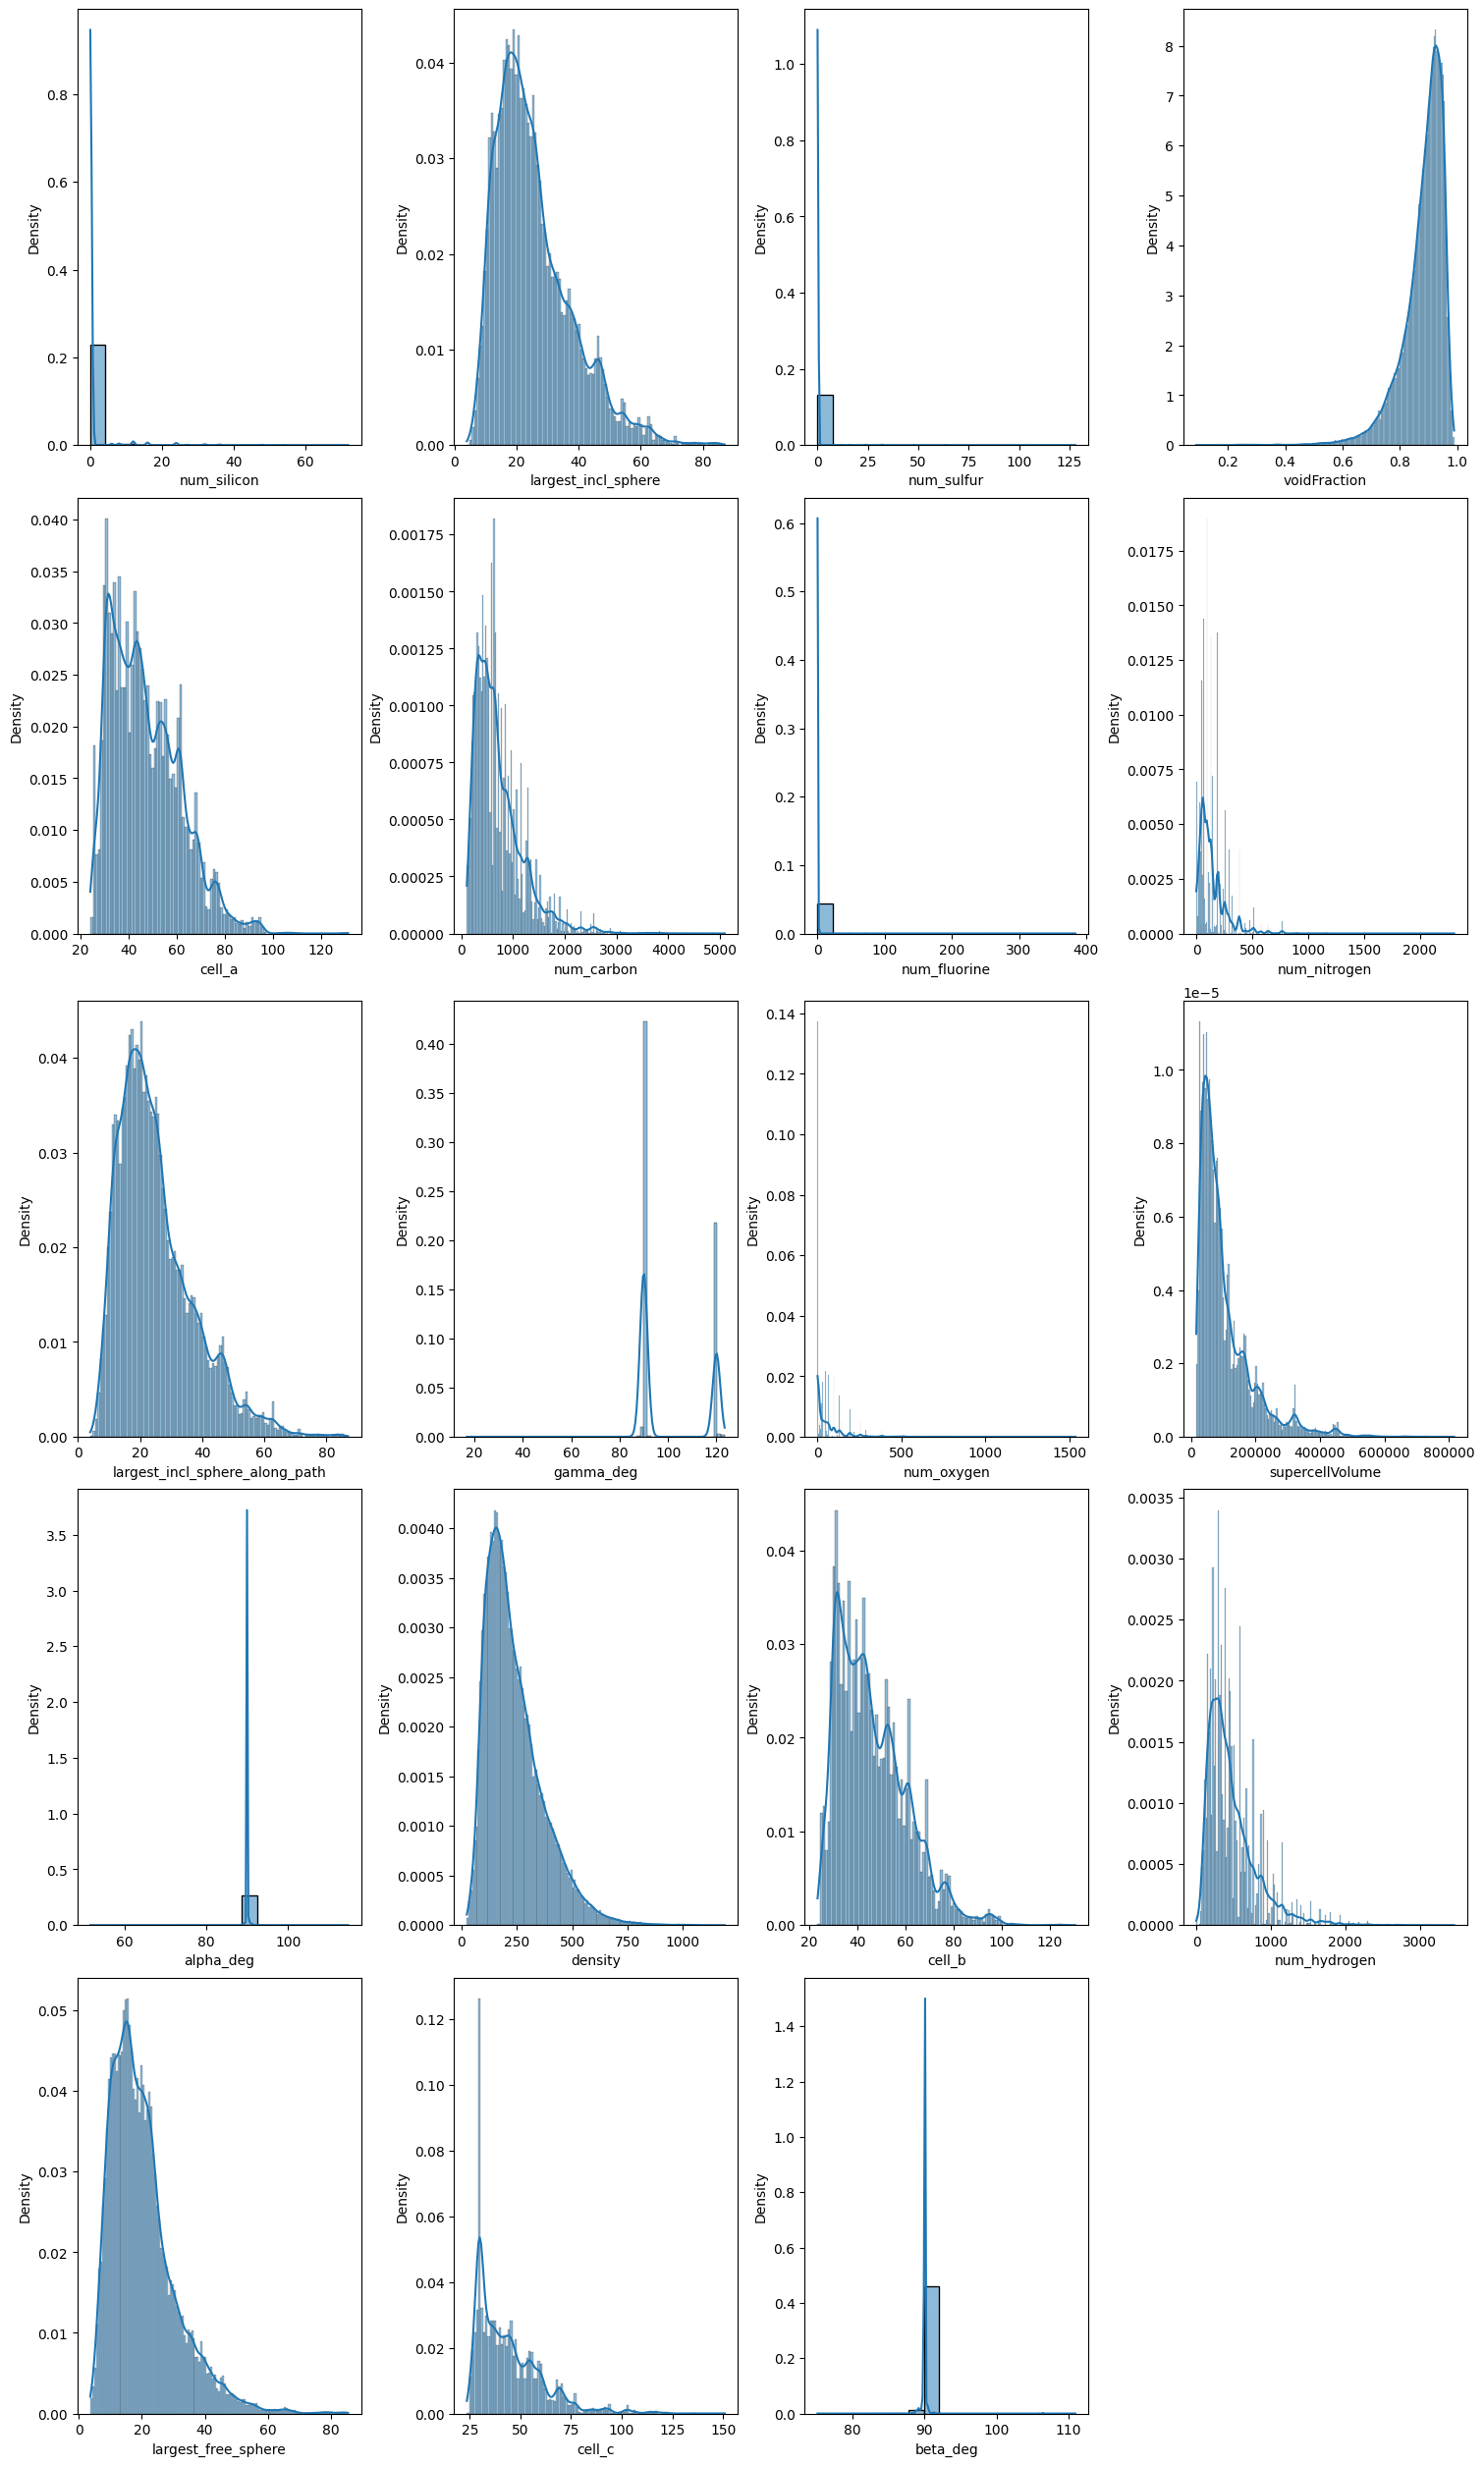

In [17]:
num_features = len(features)
num_cols = 4
num_rows = (num_features // num_cols) + int(num_features % num_cols != 0)

fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(15, 5 * num_rows), constrained_layout=True
)

axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, kde=True, stat="density", ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Density")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

> ✍️ **Are the numerical features normally distributed? If not, what distributions do they follow, and how might this impact model training?**

The numerical features exhibit varying distributions and do not conform to a standard normal distribution. Many of them appear to be either left- or right-skewed, and in some cases, such as `gamma_deg`, the data shows multiple modes. This indicates the need for standardization to ensure the features are on a consistent scale for model training.

### Correlation Analysis

Let's analyze the correlation between features and the target variable, as well as relationships among features, to gain insights. A correlation heatmap makes it easy to spot strong positive or negative correlations, helping identify dependencies and select useful features for the model.

> 💡 Use [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation matrix, which returns the pairwise correlations between all features and the target variable. Then, use [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to visualize this matrix.

<Axes: >

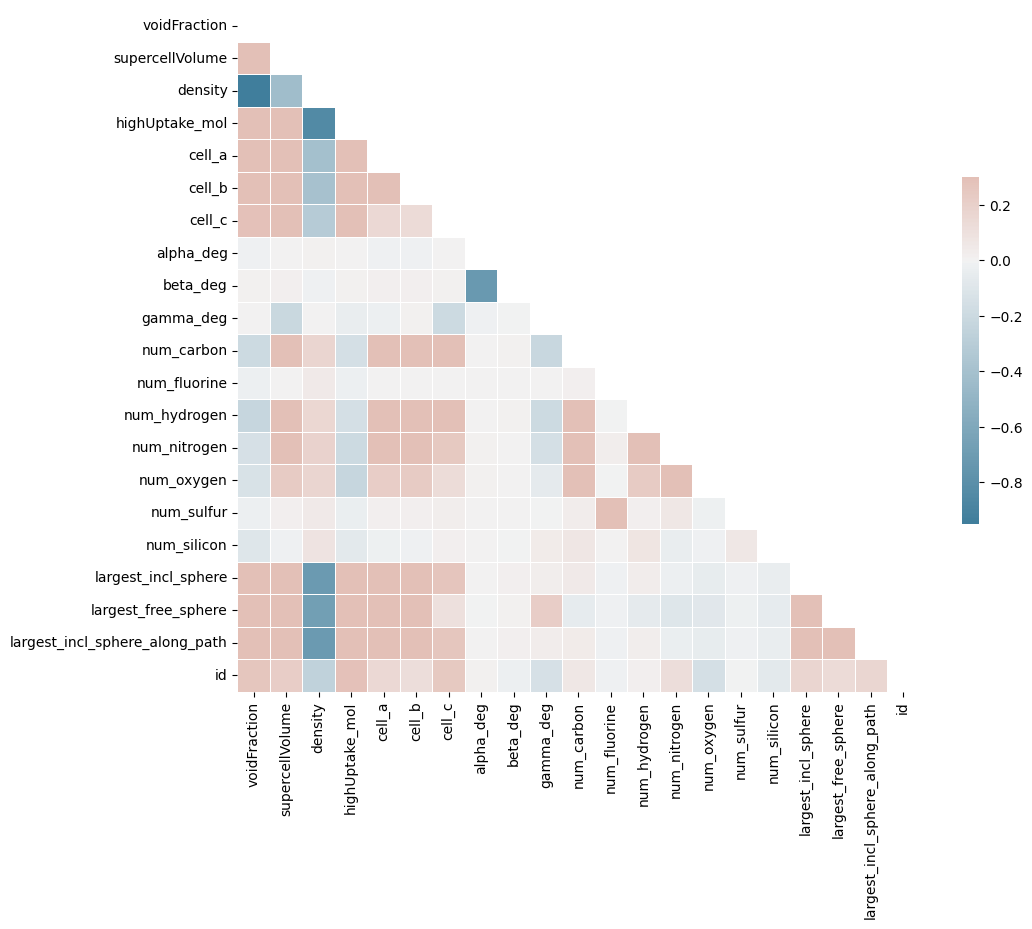

In [18]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)


> 💡 Use [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to calculate the correlation between features and the target variable. Then, apply [`pandas.Series.abs`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.abs.html) to get the absolute values of the correlations. This makes it easier to identify features with weak relationships to the target, which are likely to have minimal impact on your model. Sorting the correlations can further help pinpoint low-impact features that may be excluded to simplify the model.

In [19]:
df.corr()[target_variable].abs().drop(target_variable).sort_values()

alpha_deg                         0.000760
beta_deg                          0.007272
num_fluorine                      0.031165
num_sulfur                        0.033391
gamma_deg                         0.039393
num_silicon                       0.074038
num_hydrogen                      0.149288
num_carbon                        0.154583
num_nitrogen                      0.197774
num_oxygen                        0.228096
id                                0.291683
cell_c                            0.347509
cell_b                            0.412106
cell_a                            0.429325
supercellVolume                   0.512285
largest_free_sphere               0.702790
largest_incl_sphere_along_path    0.756785
largest_incl_sphere               0.759943
voidFraction                      0.803979
density                           0.845106
Name: highUptake_mol, dtype: float64

> ✍️ **Can some features be omitted? Are there high correlations between features? How can they be addressed?**

We observe significant negative correlations among several features, indicating redundancy or conflicting information that can hinder the model's ability to estimate their individual contributions.

For instance, `alpha_deg` and `beta_deg` show minimal correlation with the target variable, suggesting limited predictive value. Features like `num_fluorine`, `num_sulfur`, `gamma_deg`, and `num_silicon` may also warrant removal.

To address this, we will compare model performance with and without these features to determine their impact.

> ⏭️ In future work, we could explore more EDA techniques, like using boxplots or z-scores to check for outliers and better understand data quality. We could also use scatter plots or pair plots to uncover relationships not visible in the histograms.

### Action Plan

> ✍️ **Formulate your action plan based on your findings so far**

- The numerical features display varied, often skewed distributions, highlighting the need for normalization.
- The features with near-zero correlation to the target are likely irrelevant to methane absorption and can be excluded to simplify the dataset.

> ⏭️ As a future work, you could explore [dimensionality reduction](https://scikit-learn.org/1.5/modules/unsupervised_reduction.html), [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html), or [other methods](https://scikit-learn.org/1.5/auto_examples/inspection/plot_permutation_importance_multicollinear.html#handling-multicollinear-features) to remove highly correlated features. While performance improvement is not guaranteed, these techniques may result in faster model training times.

## 🤖 Model Selection & Evaluation

When working with machine learning workflows, one common challenge is managing multiple preprocessing steps (like scaling) and model fitting. If these steps are handled separately, several issues can arise.

If we apply scaling and fitting separately, we might accidentally apply different transformations to the training and test data. For instance, fitting the scaler on the training set and then applying it to the test set ensures the model sees data in a consistent manner. However, if we forget to apply the same transformation on the test data, this inconsistency can lead to misleading results and poor model performance.

The solution is to combine these steps into a single pipeline using [`sklearn.pipeline.Pipeline`](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html).

For normalization, we'll use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which standardizes features by removing the mean and scaling to unit variance, ensuring that all features are on a similar scale. 

> ⏭️ In future work, we could experiment with other scaling techniques, such as [`sklearn.preprocessing.RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html), which is less sensitive to outliers, or [`sklearn.preprocessing.MinMaxScaler`](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which scales data to a fixed range. These techniques might be preferable if the data contains outliers or if we want to ensure that the features are within a specific range for model stability.

[Choose at least 3 models](https://scikit-learn.org/stable/machine_learning_map.html) to test out, ensuring they represent a variety of approaches (e.g., linear, tree-based, and support vector methods). Ensure estimators use the `random_state` parameter where appropriate to control randomness and ensure reproducibility. Creating a function to build your pipeline makes it easier to try different configurations.

In [20]:
def create_pipeline(model_choice: str, random_state: int = RANDOM_SEED) -> Pipeline:
    steps = [("scaler", StandardScaler())]

    if model_choice == "Linear Regression":
        steps.append(("model", LinearRegression()))
    elif model_choice == "Random Forest":
        steps.append(("model", RandomForestRegressor(random_state=random_state)))
    elif model_choice == "SVM":
        steps.append(("model", SVR()))
    else:
        raise ValueError(f"Invalid model choice ({model_choice})")

    return Pipeline(steps=steps)

### Evaluating our Candidates

To evaluate our model candidates, we'll again use 5-fold [cross-validation](https://scikit-learn.org/1.5/modules/cross_validation.html). In addition to **RMSE** and **MAPE**, choose at least one other [regression evaluation metric](https://scikit-learn.org/1.5/modules/model_evaluation.html#regression-metrics) to include in your report.

We will also experiment with removing low-correlation features to simplify the model and potentially enhance performance. Showcase your results using a [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [21]:
features_all = list(set(df.columns).difference([target_variable, "id"]))
features_hc = list(set(features_all).difference(["alpha_deg", "beta_deg", "num_fluorine", "num_sulfur", "gamma_deg", "num_silicon"]))
metrics = ["neg_mean_squared_error", "neg_mean_absolute_percentage_error", "r2"]

results = {}
for model_choice in tqdm(["Linear Regression", "Random Forest", "SVM"]):
    for kind, features in tqdm(list(zip(["all", "high correlation"], [features_all, features_hc])), leave=False):
        name = f"{model_choice} ({kind})"

        results[name] = {}
        pipeline = create_pipeline(model_choice, random_state=RANDOM_SEED)

        result = cross_validate(
            pipeline, df[features], df[target_variable], cv=5, scoring=metrics
        )
        for metric in metrics:
            values = result[f"test_{metric}"]
            mean = values.mean()
            std = values.std()

            results[name][metric] = f"{mean * 100:.3f} +/- {std * 100:.3f}"

        avg_fit_time = result["fit_time"].mean()

pd.DataFrame(results).T

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,neg_mean_squared_error,neg_mean_absolute_percentage_error,r2
Linear Regression (all),-2000.036 +/- 595.457,-9.038 +/- 1.290,80.894 +/- 2.709
Linear Regression (high correlation),-2043.341 +/- 627.196,-9.095 +/- 1.284,80.506 +/- 2.958
Random Forest (all),-95.248 +/- 23.559,-2.471 +/- 0.594,99.041 +/- 0.286
Random Forest (high correlation),-95.358 +/- 23.168,-2.473 +/- 0.587,99.040 +/- 0.283
SVM (all),-391.935 +/- 207.049,-3.526 +/- 1.309,96.448 +/- 1.358
SVM (high correlation),-333.231 +/- 208.913,-3.277 +/- 1.332,96.983 +/- 1.504


> ✍️ **Why did you select this particular additional metric? How do the metrics vary across models, and what do the results reveal about each model's performance? Use these insights to select the best-performing model.**

**$R^2$** measures the proportion of variance in the target variable that can be explained by the model, helping to evaluate how well the model fits the data. An $R^2$ value of 1 indicates perfect prediction, while a value of 0 means the model does not explain any of the variance in the target variable. The formula for **$R^2$** (coefficient of determination) is:

$$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

Where:
- $y_i$ is the actual value of the target variable,
- $\hat{y}_i$ is the predicted value of the target variable,
- $\bar{y}$ is the mean of the actual values,
- $n$ is the number of data points.

$R^2$, Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE) are commonly used regression metrics and provide complementary insights into model performance. 

> ⏭️ As future work, we could explore additional evaluation metrics for regression, such as [Mean Squared Logarithmic Error (MSLE)](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_log_error.html), [Explained Variance Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html), or [Median Absolute Error (MedAE)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html), to gain further insights into the model's performance. Additionally, looking into the [training and inference times](https://scikit-learn.org/1.5/modules/cross_validation.html#the-cross-validate-function-and-multiple-metric-evaluation) of different pipeline configurations would help optimize the workflow and improve efficiency.

Our results show that the **Random Forest** model significantly outperforms the other models. Whether using all features or only selecting those most strongly correlated with the target, performance remains virtually the same. Using high-correlation features can help eliminate unnecessary or irrelevant data, making the model simpler and faster. To conclude, we will train a Random Forest model using only the highly correlated features.

## 🔝 Ranking Materials

Predict the methane adsorption capacity of the materials in the test set using your best model and rank them to identify the top performer. The actual top performers are listed below. How does your model compare?

|   | id    | highUptake_mol |
|---|-------|----------------|
| 0 | 69403 | 138.583930     |
| 4 | 66217 | 127.384576     |
| 2 | 69353 | 123.843205     |
| 3 | 40368 | 114.783122     |
| 5 | 40356 | 113.556987     |

In [28]:
pipeline = create_pipeline("Random Forest", random_state=RANDOM_SEED)
pipeline.fit(df[features_hc], df[target_variable])

df_test = pd.read_csv("./data/test.csv")
y_pred = pipeline.predict(df_test[features_hc])

pd.DataFrame({"id": df_test["id"], target_variable: y_pred}).sort_values(
    target_variable, ascending=False
)

,id,highUptake_mol
0,69403,132.498699
4,66217,124.563197
2,69353,121.814673
3,40368,114.901440
5,40356,113.932221
...,...,...
58,45838,20.404622
39,13337,19.590999
63,28266,18.371485
68,37107,15.300664


## 🎌 Creating the Submission File

1. **Prepare the Submission**: Keep only the `id` column and the predicted `highUptake_mol` column in your DataFrame.
2. **Save as CSV**: Export the DataFrame as a CSV file, ensuring to exclude the index.

> 💡 Use [`pandas.DataFrame.to_csv`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) to save the DataFrame.

In [29]:
submission = pd.DataFrame({"id": df_test["id"], target_variable: y_pred})
submission.to_csv("submission.csv", index=False)